AutoEncoders are widely used in anomaly detection. The reconstruction errors are used as the anomaly scores. Let us look at how we can use AutoEncoder for anomaly detection using TensorFlow.

Import the required libraries and load the data. Here we are using the ECG data which consists of labels 0 and 1. Label 0 denotes the observation as an anomaly and label 1 denotes the observation as normal.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

# Download the dataset
PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
data = pd.read_csv(PATH_TO_DATA, header=None)
data.head()

Init Plugin
Init Graph Optimizer
Init Kernel


,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [2]:
data.shape

(4998, 141)

In [3]:
# last column is the target
# 0 = anomaly, 1 = normal
TARGET = 140

features = data.drop(TARGET, axis=1)
target = data[TARGET]

x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target
)

# use case is novelty detection so use only the normal data
# for training
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

# min max scale the input data, train Scaler using x_train, transform
# both x_train and x_test using the min_max_scaler model
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

The last column in the data is the target ( column name is 140). Split the data for training and testing and scale the data using MinMaxScaler.

In [15]:
# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/20
1/5 [=====>........................] - ETA: 1s - loss: 0.0112 - mse: 0.0250

2022-05-22 13:00:09.508286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 53ms/step - loss: 0.0114 - mse: 0.0254 - val_loss: 0.0130 - val_mse: 0.0300
Epoch 2/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0110 - mse: 0.0246 - val_loss: 0.0128 - val_mse: 0.0294
Epoch 3/20
1/5 [=====>........................] - ETA: 0s - loss: 0.0109 - mse: 0.0242

2022-05-22 13:00:09.803255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 20ms/step - loss: 0.0104 - mse: 0.0231 - val_loss: 0.0123 - val_mse: 0.0283
Epoch 4/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0093 - mse: 0.0207 - val_loss: 0.0119 - val_mse: 0.0273
Epoch 5/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0082 - mse: 0.0182 - val_loss: 0.0117 - val_mse: 0.0267
Epoch 6/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0073 - mse: 0.0161 - val_loss: 0.0110 - val_mse: 0.0252
Epoch 7/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0065 - mse: 0.0144 - val_loss: 0.0105 - val_mse: 0.0241
Epoch 8/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0059 - mse: 0.0132 - val_loss: 0.0102 - val_mse: 0.0235
Epoch 9/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0055 - mse: 0.0123 - val_loss: 0.0098 - val_mse: 0.0226
Epoch 10/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0052 - mse: 0.0117 - val_loss: 0.0

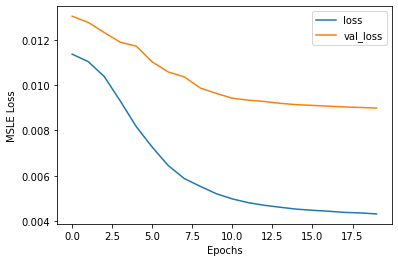

In [5]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [6]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261
predictions = get_predictions(model, x_test_scaled, threshold)
accuracy_score(predictions, y_test)
# 0.946

2022-05-22 12:08:36.325448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Threshold: 0.009491399820103868


0.946

The reconstruction errors are considered to be anomaly scores or complexity scores. The threshold is then calculated by summing the mean and standard deviation of the reconstruction errors. The reconstruction errors above this threshold are considered to be anomalies. We can further fine-tune the model by leveraging Keras-tuner.
Initialize a tuner (here, RandomSearch). We use objective to specify the objective to select the best models, and we use max_trials to specify the number of different models to try.